In [1]:
import pandas as pd
import yaml

In [2]:
#YAMLファイルを読み込む
with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)


In [3]:
df=pd.read_csv(config['train_path'])
print(df)

      writing_id                                               body  author
0              0  \r\n　先ごろの本欄に僕の「風報」にかいた「天皇陛下に捧ぐる言葉」を評して俗うけを狙った媚...       0
1              1  \r\n　旅の眼に映じた外国の正月をといふお需めで、一昔前の記憶から探してみたが、其処にはほ...       0
2              2  \r\n　或る心持のよい夕方、日比谷公園の樹の繁みの間で、若葉楓の梢を眺めていたら、どこから...       0
3              3  \r\n\r\n［＃３字下げ］一［＃「一」は中見出し］\r\n\r\n　島々《しま／＼》と云...       1
4              7  \r\n\r\n　或る田舎に母と子とが住んでいた。そして或る年の秋、次のようなことがあった。...       0
...          ...                                                ...     ...
3307        4724  \r\n\r\n［＃９字下げ］一［＃「一」は中見出し］\r\n\r\n　八五郎の取柄は、誰と...       0
3308        4728  \r\n\r\n　ある婦人が私に言つた。私が情痴作家などゝ言はれることは、私が小説の中で作者...       0
3309        4729  \r\n\r\n　諸君は、東京市某町某番地なる風博士の邸宅を御存じであろう乎《か》？　御存じ...       0
3310        4730  \r\n\r\n［＃９字下げ］一［＃「一」は中見出し］\r\n\r\n「御免」\r\n　少し...       0
3311        4731  \r\n\r\n　ちやうど今日（十月三日）文部省で著作家側を招いて新カナヅカイと漢字の問題で...       0

[3312 rows x 3 columns]


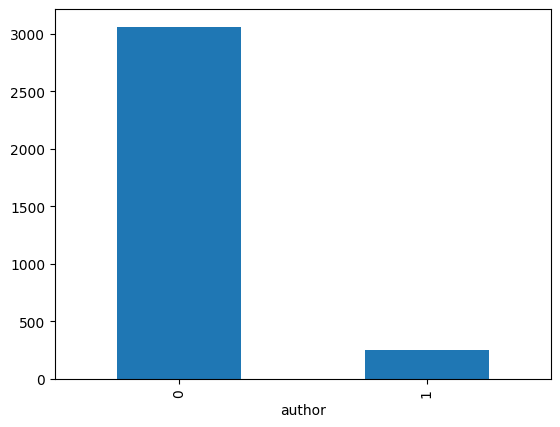

In [4]:
import matplotlib.pyplot as plt

df['author'].value_counts().plot(kind='bar')
plt.show()

In [5]:
import glob
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import BertJapaneseTokenizer, BertForSequenceClassification
import random
import numpy as np
from tqdm import tqdm
import mlflow
from transformers import BertModel
import torch.optim as optim
from transformers import get_cosine_schedule_with_warmup
import transformers
from model import EarlyStopper
from sklearn.metrics import f1_score

/home/bdr/kaggle/kaggle/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['author'], random_state=42)
train_df

,writing_id,body,author
255,356,\r\n\r\n 一 或る図書館員の話\r\n\r\n 掘割の橋のたもとで、いつも自...,0
3177,4544,\r\n\r\n 僕に小説をかけと云ふのかね。書けるのなら、とうに書いてゐるさ。が、書けない...,1
959,1368,\r\n\r\n どんな時代でも文化について政策が考えられるとき、それが建設的でなければなら...,0
1520,2154,\r\n\r\n 昔《むかし》、ある国《くに》に有名《ゆうめい》な陶器師《とうきし》がありま...,0
2843,4074,\r\n\r\n こんど同行する湯浅芳子さんは七月頃既に旅券が下附されていたのだが、私が行く...,0
...,...,...,...
1224,1722,\r\n\r\n「伸子」は、一九二四年頃から三年ほどかかって書かれた。丁度、第一次ヨーロッパ...,0
1359,1918,\r\n\r\n 或日《あるひ》の暮方の事である。一人の下人が、羅生門《らしやうもん》の下で...,1
797,1133,\r\n\r\n 自動車の中で、自分は安倍さんの左側に腰掛けた。自分の左には山口さんが居た。...,0
654,919,\r\n\r\n［＃ここから５字下げ］\r\n中流家庭の茶の間――奥の障子を隔てて台所――衣...,0


In [7]:
'''
df['fold']=df.index%5
train_df=df[df['fold']!=0].reset_index(drop=True)
val_df=df[df['fold']==0].reset_index(drop=True)
train_df
'''

"\ndf['fold']=df.index%5\ntrain_df=df[df['fold']!=0].reset_index(drop=True)\nval_df=df[df['fold']==0].reset_index(drop=True)\ntrain_df\n"

In [8]:
tokenizer=BertJapaneseTokenizer.from_pretrained(config['MODEL_NAME'])
'''
    sen_length = []

    for sentence in tqdm(df["body"]):

        token_words = tokenizer.encode_plus(sentence)["input_ids"]
        sen_length.append(len(token_words))

    print('maxlenth of all sentences are  ', max(sen_length))
'''

'\n    sen_length = []\n\n    for sentence in tqdm(df["body"]):\n\n        token_words = tokenizer.encode_plus(sentence)["input_ids"]\n        sen_length.append(len(token_words))\n\n    print(\'maxlenth of all sentences are  \', max(sen_length))\n'

In [9]:

class BERTDataSet(Dataset):
    
    def __init__(self,data,tokenizer,mode='train'):
        self.data=data
        self.mode=mode
        self.tokenizer=tokenizer
        self.sentences = self.data["body"].tolist()
        if self.mode != 'test':
            self.labels = self.data["author"].tolist()
        
    def __len__(self):
        
        return len(self.sentences)
    
    def __getitem__(self,idx):
        
        sentence = self.sentences[idx]

        if self.mode != 'test':
            label = torch.tensor(self.labels[idx],dtype=torch.long)
        
        bert_sens = tokenizer.encode_plus(
                                sentence,
                                add_special_tokens = True, 
                                max_length = 512, 
                                padding = 'max_length', 
                                return_attention_mask = True,
                                return_tensors='pt',
                                truncation=True)
        ids = bert_sens['input_ids'].clone().detach().squeeze()
        mask = bert_sens['attention_mask'].clone().detach().squeeze()
        token_type_ids = bert_sens['token_type_ids'].clone().detach().squeeze()

        if self.mode != 'test':
            return {
                'ids': ids,
                'mask': mask,
                'token_type_ids': token_type_ids,
                'labels': label
            }
        else:
            return {
                    'ids': ids,
                    'mask': mask,
                    'token_type_ids': token_type_ids,
                }
    
tokenizer=BertJapaneseTokenizer.from_pretrained(config['MODEL_NAME'])


In [10]:

train_dataset = BERTDataSet(data=train_df,tokenizer=tokenizer)
valid_dataset = BERTDataSet(data=val_df,tokenizer=tokenizer)


In [11]:
train_dataloader=DataLoader(train_dataset,batch_size=config['TRAIN_BATCH'],shuffle=True,num_workers=0,pin_memory=True)
val_dataloader=DataLoader(valid_dataset,batch_size=config['VAL_BATCH'],shuffle=False,num_workers=0,pin_memory=True)

In [12]:
bert_model = BertModel.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')

# 線形層の追加
class BertForSequenceClassification(nn.Module):
    def __init__(self, bert_model, num_labels):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(bert_model.config.hidden_dropout_prob)
        self.classifier = nn.Linear(bert_model.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits

num_labels = 2
model = BertForSequenceClassification(bert_model, num_labels)

In [13]:
import torch.optim as optim

# 事前学習済の箇所は学習率小さめ、最後の全結合層は大きめにする。
optimizer = optim.Adam([
    {'params': model.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


# 損失関数の設定
loss_function = nn.CrossEntropyLoss()
model.to(config['DEVICE'])

early_stopping = EarlyStopper()

In [14]:
train_loss=[]
valid_loss=[]

for epoch in range(config['EPOCH']):
    model.train()
    total_loss = 0
    total_acc=0
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{config["EPOCH"]}', leave=False)
    for batch in progress_bar:
        input_ids = batch['ids'].to(config['DEVICE'])
        attention_mask = batch['mask'].to(config['DEVICE'])
        labels = batch['labels'].to(config['DEVICE'])
        token_type_ids = batch['token_type_ids'].to(config['DEVICE'])
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = loss_function(outputs, labels)
        total_loss += loss.item()

        acc=(outputs.argmax(1)==labels).sum().item()
        total_acc+=acc
        
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'Loss': total_loss / len(train_dataloader), 'Acc': total_acc *100/ len(train_dataloader.dataset)})
    
    # Validation loop
    model.eval()
    val_loss = 0
    val_acc=0
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['ids'].to(config['DEVICE'])
            attention_mask = batch['mask'].to(config['DEVICE'])
            labels = batch['labels'].to(config['DEVICE'])
            token_type_ids = batch['token_type_ids'].to(config['DEVICE'])
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = loss_function(outputs, labels)
            acc=(outputs.argmax(1)==labels).sum().item()
            val_loss += loss.item()
            val_acc+=acc



    
    # Update the learning rate scheduler
    scheduler.step()

    early_stopping.update(val_loss/len(val_dataloader), model)

    if early_stopping.early_stop:
        print('Early stopping !')
        break
    

    train_loss.append(total_loss/len(train_dataloader))
    valid_loss.append(val_loss/len(val_dataloader))
    print(f'Epoch {epoch + 1}/{config["EPOCH"]}: Train Loss = {total_loss / len(train_dataloader)}, Val Loss = {val_loss/ len(val_dataloader)}')

model = early_stopping.load_checkpoint(model)

Validation accuracy increased (inf --> 0.118248).  Saving model ...
Epoch 1/50: Train Loss = 0.21858865129256463, Val Loss = 0.11824810274300121


Validation accuracy increased (0.118248 --> 0.096423).  Saving model ...
Epoch 2/50: Train Loss = 0.08202916195795658, Val Loss = 0.09642328299759399


Validation accuracy increased (0.096423 --> 0.094716).  Saving model ...
Epoch 3/50: Train Loss = 0.08165531634656062, Val Loss = 0.09471580603470404


Validation accuracy increased (0.094716 --> 0.094504).  Saving model ...
Epoch 4/50: Train Loss = 0.07864256382145617, Val Loss = 0.0945043254732376


Validation accuracy increased (0.094504 --> 0.094488).  Saving model ...
Epoch 5/50: Train Loss = 0.07785763392079038, Val Loss = 0.09448846172363985


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 6/50: Train Loss = 0.08006792026852448, Val Loss = 0.09448820747257698


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 7/50: Train Loss = 0.07787532485314612, Val Loss = 0.09448820702909004


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 8/50: Train Loss = 0.07982234344032245, Val Loss = 0.09448820649690572


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 9/50: Train Loss = 0.07975173739054386, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 10/50: Train Loss = 0.08000229441572025, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 11/50: Train Loss = 0.0768187761907073, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 12/50: Train Loss = 0.08077857236613531, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 13/50: Train Loss = 0.08014645756233528, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 14/50: Train Loss = 0.07854911724823606, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 15/50: Train Loss = 0.07540827470057342, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 16/50: Train Loss = 0.07931036067318666, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 17/50: Train Loss = 0.07795457139959087, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 18/50: Train Loss = 0.07845365738844028, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 19/50: Train Loss = 0.07650321291714728, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 20/50: Train Loss = 0.07819239700392606, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 21/50: Train Loss = 0.07786689898145037, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 22/50: Train Loss = 0.07614994239264045, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 23/50: Train Loss = 0.08085149630668562, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 24/50: Train Loss = 0.07873156334901879, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 25/50: Train Loss = 0.0775548568113247, Val Loss = 0.09448820614211616


Validation accuracy increased (0.094488 --> 0.094488).  Saving model ...
Epoch 26/50: Train Loss = 0.07859956980570702, Val Loss = 0.09448820614211616


Epoch 27/50:  79%|███████▉  | 131/166 [01:33<00:25,  1.37it/s, Loss=0.0601, Acc=77]  

In [ ]:
print(train_loss)

[]


In [ ]:
predict_df=pd.read_csv(config['test_path'])
print(predict_df.head())

   writing_id                                               body
0           4  \r\n\r\n　　　　　一\r\n\r\n　夕方降り出した雨はその晩遅くまで続いた。しとし...
1           5  \r\n\r\n　この「東北文学」という雑誌の貴重な紙面の端をわずか拝借して申し上げます。ど...
2           6  \r\n\r\n　幼少のころ、高知《こうち》の城下から東に五六里離れた親類の何かの饗宴《きょ...
3          10  \r\n\r\n　　　　　　　　　　　　　○\r\n「三人姉妹」で、マーシャがどんな風に活か...
4          11  \r\n\r\n［＃５字下げ］眼鏡［＃「眼鏡」は中見出し］\r\n\r\n　或日、趣味に関し...


In [ ]:
test_dataset=BERTDataSet(data=predict_df,tokenizer=tokenizer,mode='test')
test_dataloader = DataLoader(test_dataset, batch_size=config['TEST_BATCH'], shuffle=False, num_workers=0, pin_memory=True)
model.eval()
predictions = []
labels=[]
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Generating Predictions', leave=False):
        input_ids = batch['ids'].to(config['DEVICE'])
        attention_mask = batch['mask'].to(config['DEVICE'])
        token_type_ids = batch['token_type_ids'].to(config['DEVICE'])
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        predictions.extend(probabilities.tolist())
        predicted_labels = torch.argmax(probabilities, dim=1)
        labels.extend(predicted_labels.tolist())

In [ ]:
predict_df['author'] = labels
predict_df.drop('body', axis=1, inplace=True)
predict_df

,writing_id,author
0,4,0
1,5,0
2,6,0
3,10,0
4,11,0
...,...,...
1415,4716,0
1416,4719,0
1417,4725,0
1418,4726,0


In [ ]:
predict_df.to_csv(config['output_path']+'predictions.csv', index=False)